In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image, clear_output
import os
import imageio.v2 as imageio
import json
import matplotlib.patches as patches
import glob
import random

np.random.seed(42)

# https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html
# https://github.com/taipingeric/yolo-v4-tf.keras/blob/master/class_names/coco_classes.txt


net = cv2.dnn.readNetFromDarknet('./models/yolo/yolov3.cfg', './models/yolo/yolov3.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_INFERENCE_ENGINE)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

THRESHOLD_PROBABILITY = 0.6
THRESHOLD_IoU = 0.4
IMAGE_WIDTH = 32*30
IMAGE_HEIGHT = 32*20

# Step 0: Familiarization with dataset
Preparing dataset & YOLO and UNet architectures

### Preparing the network

In [2]:
ln = net.getLayerNames()
print(ln)

output_ln = net.getUnconnectedOutLayersNames()
print(output_ln)

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

### Prepare dataset - download, unzip

{root}/{type}{video}/{split}/{city}/{city}_{seq:0>6}_{frame:0>6}_{type}{ext}

In [194]:
''' Bounding boxes '''
# gtBbox_cityPersons
# https://www.cityscapes-dataset.com/downloads/

'''
gtBbox_cityPersons_trainval.zip (2.2MB) [md5]
CityPersons bounding box annotations of people for train and val sets (3475 annotated images). Citation: S. Zhang, R. Benenson, and B. Schiele, "CityPersons: A Diverse Dataset for Pedestrian Detection", CVPR 2017.

- M. Cordts, M. Omran, S. Ramos, T. Rehfeld, M. Enzweiler, R. Benenson, U. Franke, S. Roth, and B. Schiele, "The Cityscapes Dataset for Semantic Urban Scene Understanding," in CVPR 2016.
- S. Zhang, R. Benenson, and B. Schiele, "CityPersons: A Diverse Dataset for Pedestrian Detection," in CVPR 2017.

'''

import zipfile
with zipfile.ZipFile("gtBbox_cityPersons_trainval.zip","r") as zip_ref:
    zip_ref.extractall("./data/")

In [192]:
''' Segmentations '''

# https://www.cityscapes-dataset.com/downloads/

'''
gtFine_trainvaltest.zip (241MB) [md5]
fine annotations for train and val sets (3475 annotated images) and dummy annotations (ignore regions) for the test set (1525 images)
'''

import zipfile
with zipfile.ZipFile("gtFine_trainvaltest.zip","r") as zip_ref:
    zip_ref.extractall("./data/")


In [193]:
''' Images '''

# https://drive.google.com/file/d/1qjf5IObph5CEGH4750yzPhoyZI1RVka_/view?usp=sharing
# https://www.cityscapes-dataset.com/downloads/

'''
leftImg8bit_trainvaltest.zip (11GB) [md5]
left 8-bit images - train, val, and test sets (5000 images)
'''


import zipfile
with zipfile.ZipFile("leftImg8bit_trainvaltest.zip","r") as zip_ref:
    zip_ref.extractall("./data/")

### Prepare Input

OpenCV's dnn module expects the input image to be in a specific format called a "blob". A blob is a 4D numpy array (batch_size, channels, height, width) that contains the input image after some pre-processing. The blob can be fed directly into the deep neural network for inference.

In [3]:
# classes =  {0: 'person'}
classes = open('coco.names').read().strip().split('\n')
class_numbers = [range(1,len(classes))]
class_dict = {i:c for i, c in enumerate(classes)}

colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')


# Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
# Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
ids = [11, 12]
human_colors = [np.array([220, 20, 60, 255]), np.array([255, 0, 0, 255])]


### Prepare data

In [4]:
#{root}/{type}{video}/{split}/{city}/{city}_{seq:0>6}_{frame:0>6}_{type}{ext}
root = "./data"
types = {'img': 'leftImg8bit', 'semantic': 'gtFine', 'instance': 'gtFine', 'bbox': 'gtBboxCityPersons'}
versions = {'img': '', 'semantic': '_color', 'instance': '_instanceIds', 'bbox': ''}
splits = ['train', 'val', 'test']
train_citities = os.listdir(f"{root}/{types['img']}/{splits[0]}")

print(train_citities)                 

['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']


./data/leftImg8bit/train/aachen/aachen_000019_000019_leftImg8bit.png


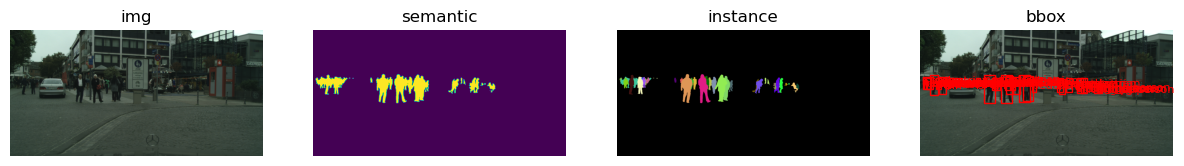

In [42]:
def visualize_example(split_id, example):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    print(f"{root}/{types['img']}/{splits[split_id]}/{train_citities[0]}/{train_citities[0]}_{example}_{types['img']}{versions['img']}.png")

    for i, t in enumerate(types.keys()):
        if t == 'bbox':
            img = imageio.imread(f"{root}/{types['img']}/{splits[split_id]}/{train_citities[0]}/{train_citities[0]}_{example}_{types['img']}{versions['img']}.png")
            axes[i].imshow(img)
            axes[i].axis('off')  # Turn off axis labels
            axes[i].set_title(t)
            with open(f"{root}/{types[t]}/{splits[split_id]}/{train_citities[0]}/{train_citities[0]}_{example}_{types[t]}{versions[t]}.json") as f:
                data = json.load(f)
                for obj in data.get("objects", []):
                    box = obj.get("bbox", [])
                    label = obj.get("label", [])
                    if label == 'ignore':
                        continue
                    x, y, width, height = box
                    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
                    axes[i].add_patch(rect)
                    axes[i].text(x, y, label, color='r', backgroundcolor='none', fontsize=8, verticalalignment='top')

            continue
        else:
            img = imageio.imread(f"{root}/{types[t]}/{splits[split_id]}/{train_citities[0]}/{train_citities[0]}_{example}_{types[t]}{versions[t]}.png")

        if t == 'semantic':
            img = np.all(np.logical_or(img == human_colors[0], img== human_colors[1]), axis=2)
            img = img.reshape(*img.shape, 1)
            img = img.astype(np.uint8) * 255

        if t == 'instance':
            pixels = img.reshape(-1)
            unique_pixels = np.unique(pixels, axis=0)
            good_pixels = []
            for color in unique_pixels:
                if str(color)[:2] in ['24', '25']:
                    good_pixels.append(color)
            new_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

            # Copy pixels from the original image where color is in good_pixels
            for id, color in enumerate(good_pixels):
                mask = (img == int(color))
                # just for visualization
                random_color = np.random.randint(0, 256, size=(1, 1, 3), dtype=np.uint8)
                new_img[mask] = random_color

            img = new_img


        # Display the image in the i-th subplot
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels
        axes[i].set_title(t)

visualize_example(0, '000019_000019')

In [45]:
def get_bboxes(paths):
    bboxes = []

    for file_path in paths:
        with open(file_path) as file:
            try:
                data = json.load(file)
                original_width, original_height = data.get('imgWidth'), data.get('imgHeight')
                # Assuming 'bbox' is a key in each object
                bboxes_f = [obj.get('bbox', None) for obj in data.get('objects') if obj.get('label') != 'ignore']

                for i, bbox in enumerate(bboxes_f):
                    # Calculate scale factors
                    width_scale = IMAGE_WIDTH / original_width
                    height_scale = IMAGE_HEIGHT / original_height

                    # Calculate resized bounding box coordinates
                    resized_bbox = [
                        int(bbox[0] * width_scale),
                        int(bbox[1] * height_scale),
                        int(bbox[2] * width_scale),
                        int(bbox[3] * height_scale)
                    ]
                    bboxes_f[i] = resized_bbox

                bboxes.append(bboxes_f)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON in file {file_path}: {e}")
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    return bboxes

In [200]:
x_train  = glob.glob(os.path.join("data" , "leftImg8bit"   , "train" , "*" , "*.png" ))
x_val = glob.glob(os.path.join( "data" , "leftImg8bit"   , "val" , "*" , "*.png" ))
# x_test = glob.glob(os.path.join( "data" , "leftImg8bit"   , "test" , "*" , "*.png" ))

bbox_train = get_bboxes(glob.glob(os.path.join("data" , "gtBboxCityPersons"   , "train" , "*" , "*.json" )))
bbox_val = get_bboxes(glob.glob(os.path.join("data" , "gtBboxCityPersons"   , "val" , "*" , "*.json" )))

In [11]:
def bounding_boxes_calculations(net_output):
  boxes = []
  confidences = []
  class_ids = []
  for output in net_output:
    for detection in output:
        probabilities = detection[5:]
        class_id = np.argmax(probabilities) # extract highest probability class
        if class_id != 0:
           # not a person class
           continue
        confidence = probabilities[class_id] # extract value of highest probability

        if confidence < THRESHOLD_PROBABILITY:
          continue

        # scale bounding box to image size
        # multiply the normalized YOLO coordinates by the width and height of the original image to get the actual pixel values
        box = detection[0:4] * np.array([IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_HEIGHT])
        (center_x, center_y, width, height) = box
        # prepare bounding box to cv format of (x_min, y_min, width, height)
        x_min = int(center_x - (width / 2))
        y_min = int(center_y - (height / 2))
        box = [x_min, y_min, int(width), int(height)] # for drawing later

        # append all
        boxes.append(box)
        confidences.append(float(confidence))
        class_ids.append(class_id)
  return (boxes, confidences, class_ids)

def draw_boxes(indexes, frame, boxes, confidences, class_ids):
  for index in indexes:
    x_min, y_min, w, h = boxes[index]
    color = [int(c) for c in colors[class_ids[index]]]

    cv2.rectangle(frame, (x_min, y_min), (x_min+w, y_min+h), color=color, thickness=2)
    text = "{}: {:.2f}".format(classes[class_ids[index]], confidences[index])
    cv2.putText(frame, text, (x_min + 5, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
  return frame

data\leftImg8bit\train\aachen\aachen_000019_000019_leftImg8bit.png
26 / 38


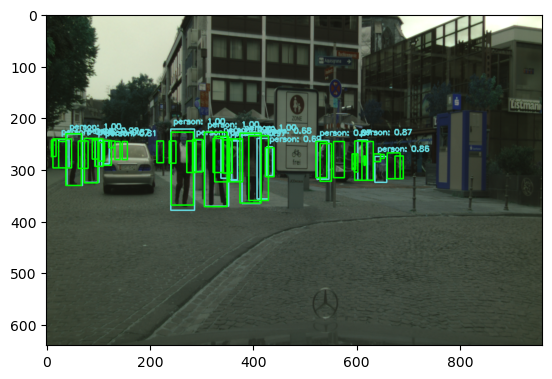

In [12]:
ex = 19
print(x_train[ex])


img = cv2.resize(cv2.imread(x_train[ex]), (IMAGE_WIDTH,IMAGE_HEIGHT), interpolation = cv2.INTER_AREA)
blob = cv2.dnn.blobFromImage(img, 1/255.0, swapRB=True, crop=False)
bbox = bbox_train[ex]
inputs, frames, ground_truth = [blob], [img], [bbox]
for id, blob in enumerate(inputs):
  frame = frames[id]
  # fowrard pass
  net.setInput(blob)
  out = net.forward(output_ln)
  # bounding boxes calculations
  boxes, confidences, class_ids = bounding_boxes_calculations(out)
  # non maximum supression to filter out boxes
  results = cv2.dnn.NMSBoxes(boxes, confidences, THRESHOLD_PROBABILITY, THRESHOLD_IoU)
  # draw boxes and text labels
  frames[id] = draw_boxes(results, frame, boxes, confidences, class_ids)
  # ground truth
  for bbox in ground_truth[id]:
    x, y, width, height = bbox
    cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)
  plt.imshow(frame)
  print(f"{len(boxes)} / {len(ground_truth[id])}")

Actually, from what we can see the ground truths have also some false positives like on the car above, therefore the evaluation here will not make much sense for our scenario (as we will focus on evaluation of instance segmentation only). Therefore, we will just use yolo without evulation of the bounding boxes themselves. Let's see how the network performes on several examples:

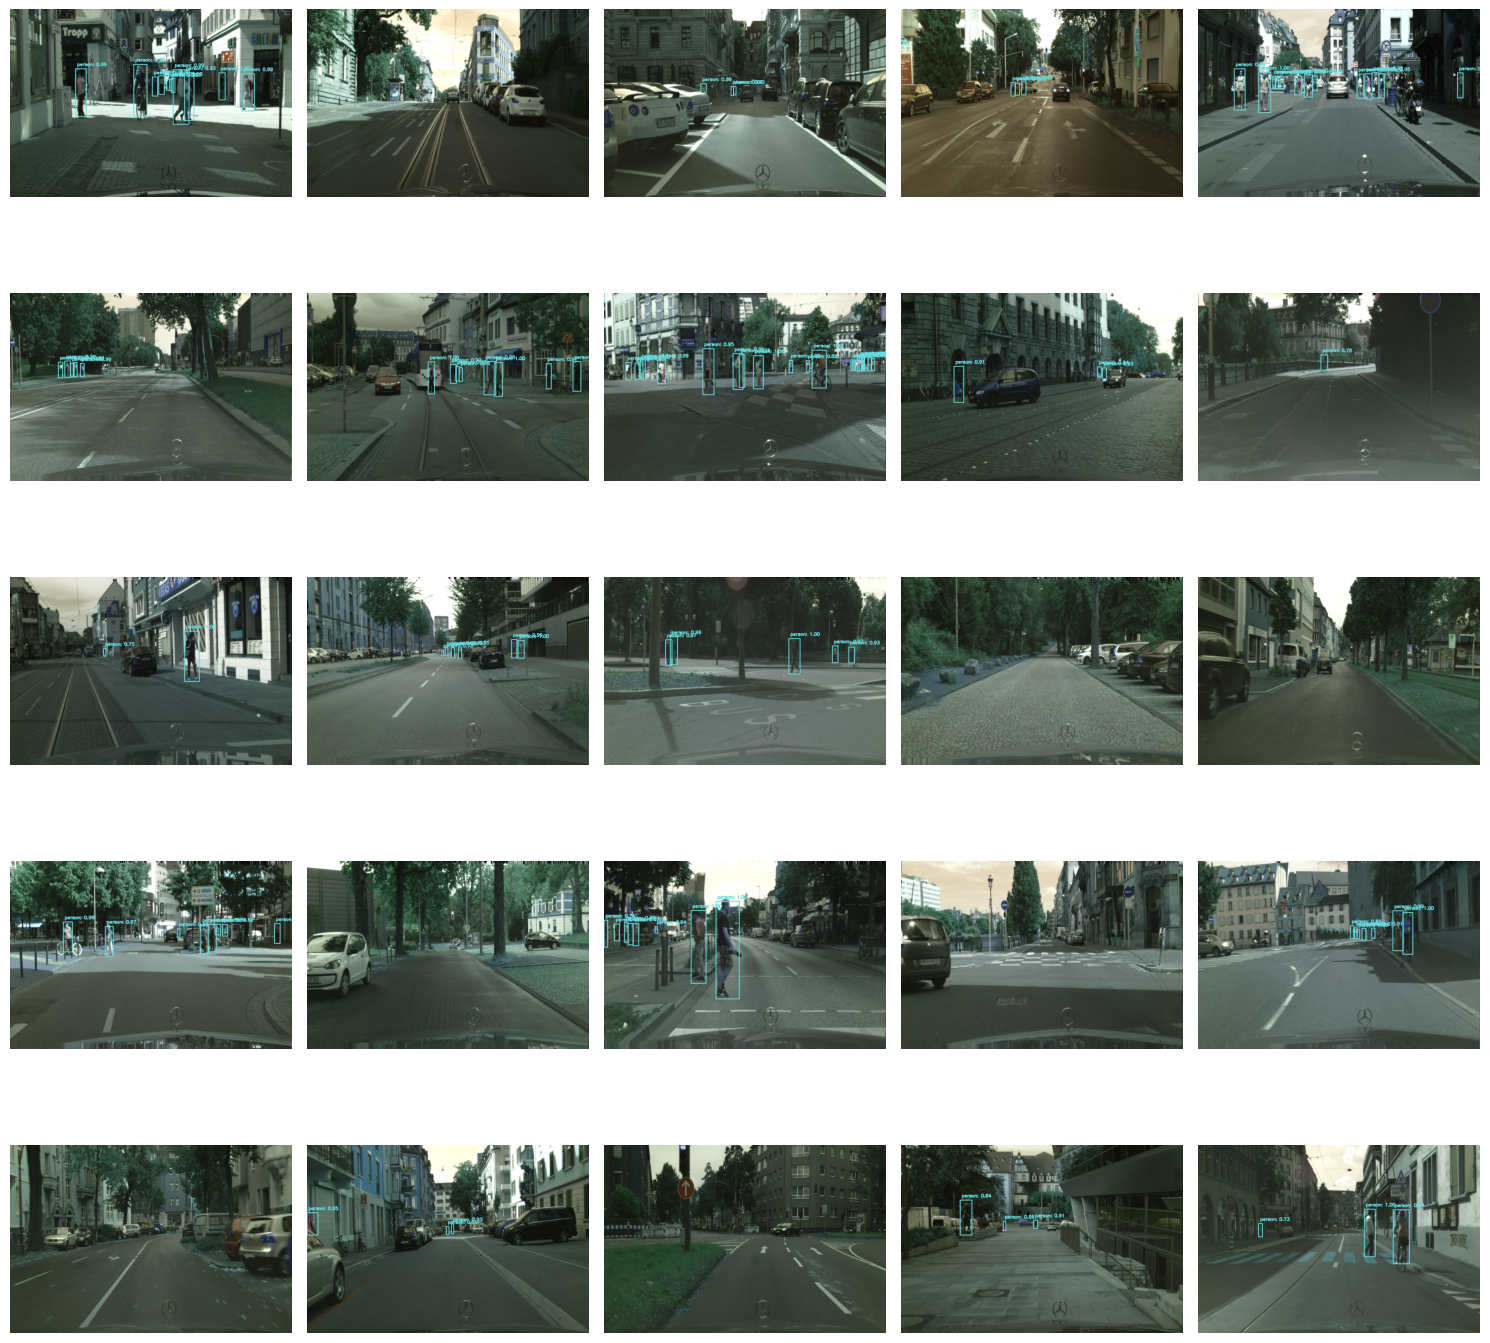

In [13]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ex = random.randint(0, len(x_train) - 1)

        img = cv2.resize(cv2.imread(x_train[ex]), (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA)
        blob = cv2.dnn.blobFromImage(img, 1/255.0, swapRB=True, crop=False)
        bbox = bbox_train[ex]


        net.setInput(blob)
        out = net.forward(output_ln)
        boxes, confidences, class_ids = bounding_boxes_calculations(out)
        results = cv2.dnn.NMSBoxes(boxes, confidences, THRESHOLD_PROBABILITY, THRESHOLD_IoU)
        img_with_boxes = draw_boxes(results, img, boxes, confidences, class_ids)

        axes[i, j].imshow(img_with_boxes)
        axes[i, j].axis('off') 


plt.tight_layout()
plt.show()

### Looks great. Now let's build semantic segmentation network based on U-Net with VGG.

Note: There are no ground truths for the test set of the original dataset. As we will be taking subset of a whole (1500 images) we will take the test examples from the training set, however we won't take the same cities as to not introduce some bias. In that way we will have complete subset of all the images & ground truth present, important for evaluation later on.

In [ ]:
size = 1500

In [201]:
filenames_train = x_train.copy()
x_train = np.array([cv2.resize(cv2.imread(ex), (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA) for ex in filenames_train[:int(0.8*size)]])
x_val = np.array([cv2.resize(cv2.imread(ex), (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA) for ex in x_val[:int(0.1*size)]])
x_test = np.array([cv2.resize(cv2.imread(ex), (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA) for ex in filenames_train[-int(0.1*size):]]) # as later there are no annotations in test set of gtFine

In [202]:
y_train = np.array([cv2.resize(cv2.imread(ex), (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA) for ex in glob.glob(os.path.join("data" , "gtFine"   , "train" , "*" , "*color.png" ))[:int(0.8*size)]])
y_val = np.array([cv2.resize(cv2.imread(ex), (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA) for ex in glob.glob(os.path.join( "data" , "gtFine"   , "val" , "*" , "*color.png" ))[:int(0.1*size)]])
y_test = np.array([cv2.resize(cv2.imread(ex), (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA) for ex in glob.glob(os.path.join( "data" , "gtFine"   , "train" , "*" , "*color.png" ))[-int(0.1*size):]])

In [203]:
# change to mask only of humans
human_colors_bgr = [np.array([60, 20, 220]), np.array([0, 0, 255])]
def create_mask(img):
    mask = np.any(np.all(img[:, :, None, :] == np.array(human_colors_bgr), axis=-1), axis=-1)
    mask_image = np.zeros_like(img, dtype=np.uint8)
    mask_image[mask] = [255, 255, 255]
    mask_image = np.max(mask_image, axis=-1)
    mask_image = np.expand_dims(mask_image, axis=-1)
    return mask_image

y_train = np.array(list(map(create_mask, y_train)))
y_val = np.array(list(map(create_mask, y_val)))
y_test = np.array(list(map(create_mask, y_test)))


In [204]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(1200, 640, 960, 3)
(1200, 640, 960, 1)
(150, 640, 960, 3)
(150, 640, 960, 1)
(150, 640, 960, 3)
(150, 640, 960, 1)


In [3]:
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from models import vgg16_unet


input_img = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

In [5]:
model = vgg16_unet.VGG16_UNet(input_img, doDropout = False, doBatchNorm=False)
net = model.network()
net.compile(optimizer=model.optimizer, loss=model.loss, metrics=['accuracy'])

In [22]:
hist = net.fit(x_train, y_train, batch_size=8, validation_data=(x_val, y_val), epochs=10, callbacks=[EarlyStopping(monitor='loss', patience=3)])

Epoch 1/10


**The training will be handled on Google Colab later on.**

Now, we can prepare dataset which will be used in experiments.

Goal:
- 1500 images total (and so smaller than original - as we will be using VGG we do not need large amount of data)
- train, val, test splitted
- semantic masks of humans
- instance colored masks with id 1...n where n is the number of people present in a given image

#### Preparing instance colored images

In [205]:
def prepare_instance_img(img):
    pixels = img.reshape(-1)
    unique_pixels = np.unique(pixels, axis=0)

    person = [color for color in unique_pixels if str(color)[:2] == '24']
    rider = [color for color in unique_pixels if str(color)[:2] == '25']

    if 24000 not in person:
        person = []
    elif 24 in person and 24000 not in person:
        person = [24]
    else:
        start_index = person.index(24000)
        continuous_sequence = [person[start_index]]
        next_value = person[start_index] + 1

        while next_value in person:
            continuous_sequence.append(next_value)
            next_value += 1
        if person[0] == 24:
            continuous_sequence = [24] + continuous_sequence
        person = continuous_sequence

    if 25000 not in rider:
        rider = []
    elif 25 in rider and 25000 not in rider:
        rider = [25]
    else:
        start_index = rider.index(25000)
        continuous_sequence = [rider[start_index]]
        next_value = rider[start_index] + 1

        while next_value in rider:
            continuous_sequence.append(next_value)
            next_value += 1
        if rider[0] == 25:
            continuous_sequence = [25] + continuous_sequence
        rider = continuous_sequence

    good_pixels = person + rider

    new_img = np.zeros_like(img)

    for id, color in enumerate(good_pixels):
        mask = (img == int(color))
        new_img[mask] = id+1

    return np.expand_dims(new_img, axis=-1)

y_instance_train = np.array([cv2.resize(cv2.imread(ex, cv2.IMREAD_UNCHANGED), (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA) for ex in glob.glob(os.path.join("data" , "gtFine"   , "train" , "*" , "*instanceIds.png" ))[:int(0.8*size)]])
y_instance_val = np.array([cv2.resize(cv2.imread(ex, cv2.IMREAD_UNCHANGED), (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA) for ex in glob.glob(os.path.join( "data" , "gtFine"   , "val" , "*" , "*instanceIds.png" ))[:int(0.1*size)]])
y_instance_test = np.array([cv2.resize(cv2.imread(ex, cv2.IMREAD_UNCHANGED), (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA) for ex in glob.glob(os.path.join( "data" , "gtFine"   , "train" , "*" , "*instanceIds.png" ))[-int(0.1*size):]])

In [206]:
y_instance_train = np.array(list(map(prepare_instance_img, y_instance_train)))
y_instance_val = np.array(list(map(prepare_instance_img, y_instance_val)))
y_instance_test = np.array(list(map(prepare_instance_img, y_instance_test)))

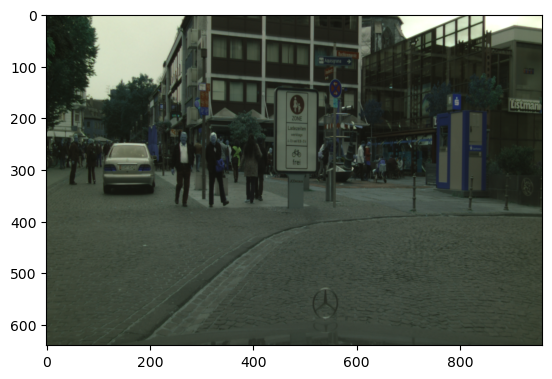

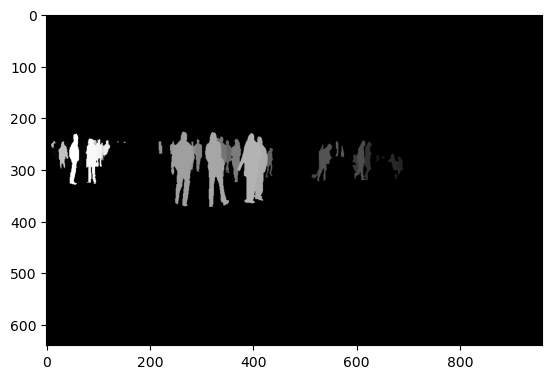

 number of human instances found: 37


In [207]:
ex = 19
plt.imshow(x_train[ex])
plt.show()
plt.imshow(y_instance_train[ex], cmap='gray')
plt.show()
print(f" number of human instances found: {np.max(y_instance_train[ex])}")

In [208]:
# check all the shapes now
print(x_train.shape)
print(y_train.shape)
print(y_instance_train.shape)

# great 

(1200, 640, 960, 3)
(1200, 640, 960, 1)
(1200, 640, 960, 1)


### Saving created dataset

In [186]:
def save_images(images, output_folder, type):
    os.makedirs(output_folder, exist_ok=True)

    for idx, image in enumerate(images):
        image = image.astype(np.uint8)
        image_path = os.path.join(output_folder, f'{type}_{idx}.png')
        cv2.imwrite(image_path, image)


In [209]:
save_images(x_train, "cityscapes/train", 'img')
save_images(y_train, "cityscapes/train", 'semantic')
save_images(y_instance_train, "cityscapes/train", 'instance')

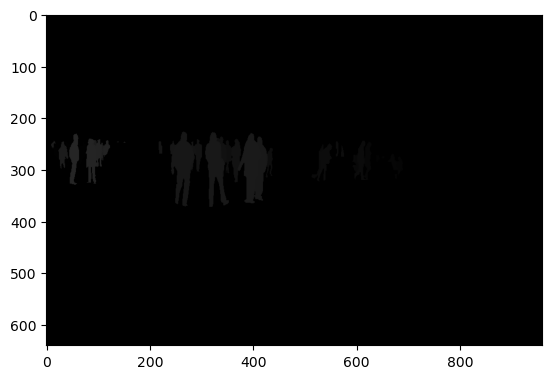

In [210]:
e = cv2.imread("./cityscapes/train/instance_19.png")
plt.imshow(e,  cmap='gray')

In [211]:
save_images(x_val, "cityscapes/val", 'img')
save_images(y_val, "cityscapes/val", 'semantic')
save_images(y_instance_val, "cityscapes/val", 'instance')

In [212]:
save_images(x_test, "cityscapes/test", 'img')
save_images(y_test, "cityscapes/test", 'semantic')
save_images(y_instance_test, "cityscapes/test", 'instance')

1


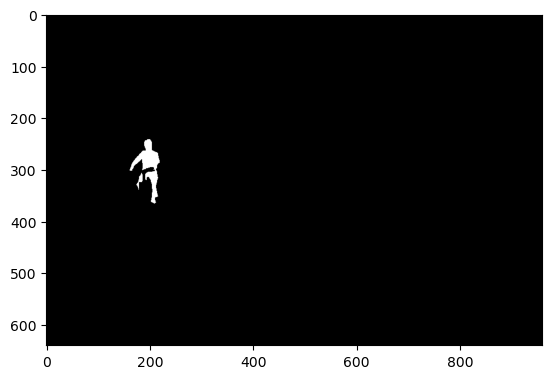

In [213]:
e = cv2.imread("./cityscapes/test/instance_1.png")
plt.imshow(e*255,  cmap='gray') # 255 just so i can see
print(np.max(e))